In [1]:
from keras import backend

Using TensorFlow backend.


In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [385]:
import numpy as np
from numpy import concatenate
from PIL import Image
filepaths = []
for name in glob.glob(r"C:\Users\benke\Documents\Year 3\Deep Learning\Xray classification\Open_I_abd_vs_CXRs\TRAIN\openI_abd_xray\*"):
    filepaths.append(name)
for name in glob.glob(r"C:\Users\benke\Documents\Year 3\Deep Learning\Xray classification\Open_I_abd_vs_CXRs\TRAIN\openI_CXR\*"):
    filepaths.append(name)
print(len(filepaths))
img = Image.open(r"C:\Users\benke\Documents\Year 3\Deep Learning\Xray classification\Open_I_abd_vs_CXRs\TRAIN\openI_abd_xray\openI_1.png")
x_train = []
for i in range(65):
    img=Image.open(filepaths[i])
    try:
        data = np.asarray( img)
    except SystemError:
        data = np.asarray( img.getdata())
    x_train.append(data)

#My issue here is all the data is of different shape 
x_train = np.array(x_train)
data = data.mean(axis=2)
print(data.shape)
print('X_data shape:', np.array(x_train).shape)

65
(512, 512)
X_data shape: (65,)


In [413]:
import keras as K
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, layers
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.regularizers import l1, l2
from keras import metrics
from keras.utils import plot_model
import pydot as pyd
from keras.applications.inception_v3 import InceptionV3
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
import pandas as pd

# dimensions of our images.
img_width, img_height = 299, 299

train_data_dir = r"C:\Users\benke\Documents\Year 3\Deep Learning\Xray classification\Open_I_abd_vs_CXRs\TRAIN"
#location of training data
validation_data_dir = r"C:\Users\benke\Documents\Year 3\Deep Learning\Xray classification\Open_I_abd_vs_CXRs\VAL"
#location of validation data

# number of samples used for determining the samples_per_epoch
nb_train_samples = 65
nb_validation_samples = 10
epochs = 20
batch_size = 5  

train_datagen = ImageDataGenerator(
        rescale=1./255,            # normalize pixel values to [0,1]
        shear_range=0.2,      
        zoom_range=0.2,    
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True) 

val_datagen = ImageDataGenerator(
        rescale=1./255)       # normalize pixel values to [0,1]

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(299,299),
    batch_size=5,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(299,299),
    batch_size=5,
    class_mode='binary')

'''
Here I've tried to convert the data into numpy arrays, I have obtained the correct shape for the data
however when I apply PCA or training the model on this data directly there is low accuracy 
'''

train_images = np.concatenate([train_generator.next()[0] for i in range(13)])
train_labels = np.concatenate([train_generator.next()[1] for i in range(13)])
val_images = np.concatenate([validation_generator.next()[0] for i in range(2)])
val_labels = np.concatenate([validation_generator.next()[1] for i in range(2)])
#print(val_images)
#print(labels)
print(train_images.shape)
print(val_images.shape)

#print(train_images)
train_images = train_images.mean(axis=3)
train_images = np.reshape(train_images,(65,89401))

val_images = val_images.mean(axis=3)
val_images = np.reshape(val_images,(10,89401))

print(train_images.shape)

Found 65 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
(65, 299, 299, 3)
(10, 299, 299, 3)
(65, 89401)


PCA done! Time elapsed: 0.5564906597137451 seconds
Variance explained per principal component: [0.20927972 0.15334481 0.09299783 0.06907844 0.0444044  0.03834081
 0.03647603 0.03383322 0.02889452 0.02738846 0.0249249  0.0237918
 0.02003684 0.01701168 0.01443224 0.01339468 0.01084382 0.01018482
 0.00944494 0.00908149 0.00889597 0.00715249]
(65, 22)


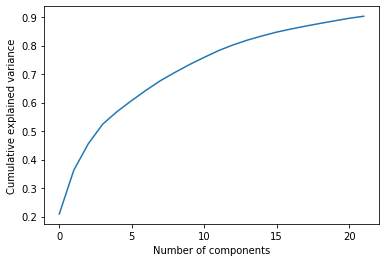

In [407]:
from sklearn.decomposition import PCA
from PIL import Image 
import os
import time

pca = PCA(0.9)
pca.fit(train_images)
PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
pca.n_components
#to capture 90% variance we need 22 PCs


time_start = time.time()
pca = PCA(n_components=22)
pca_train = pca.fit_transform(train_images)

print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
print('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))
var=pca.explained_variance_ratio_


#pca = PCA(n_components=10)
#pca_validation = pca.fit_transform(val_images)

print(pca_train.shape)
#print(pca_validation.shape)
#pca_train = np.reshape(pca_train, (65,5,5,3))
#pca_validation = np.reshape(pca_validation, (10,5,5,3))

In [15]:
base_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

In [408]:
print(base_model.input_shape[0:])
print(base_model.output_shape[0:])

(None, 299, 299, 3)
(None, 8, 8, 2048)


In [253]:
#define sequential model
model_top = Sequential()


#model_top.add(Conv2D(2048, (3, 3), input_shape=(299, 299, 3), padding='valid'))
#model_top.add(Conv2D(4096, (3, 3), input_shape=(5, 299, 299, 1), padding='valid'))
model_top.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:], data_format=None))  

#hidden layer 1
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
#hidden layer 2
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.25))
model_top.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
#output layer
model_top.add(Dense(1, activation='sigmoid')) #used ‘sigmoid’ for the output layer as this is a binary classification.

model = Model(inputs=base_model.input, outputs=model_top(base_model.output))



model.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0), loss='binary_crossentropy', metrics=['accuracy', metrics.mae])

In [412]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples // batch_size,
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples // batch_size)

Epoch 1/20
13/13 [==============================] - 65s 5s/step - loss: 0.4263 - acc: 0.8308 - mean_absolute_error: 0.2957 - val_loss: 0.1740 - val_acc: 1.0000 - val_mean_absolute_error: 0.1521
Epoch 2/20
13/13 [==============================] - 58s 4s/step - loss: 0.3512 - acc: 0.8615 - mean_absolute_error: 0.2293 - val_loss: 0.0982 - val_acc: 1.0000 - val_mean_absolute_error: 0.0888
Epoch 3/20
13/13 [==============================] - 69s 5s/step - loss: 0.2340 - acc: 0.9538 - mean_absolute_error: 0.1780 - val_loss: 0.0591 - val_acc: 1.0000 - val_mean_absolute_error: 0.0566
Epoch 4/20
13/13 [==============================] - 67s 5s/step - loss: 0.2704 - acc: 0.9385 - mean_absolute_error: 0.1508 - val_loss: 0.0713 - val_acc: 1.0000 - val_mean_absolute_error: 0.0680
Epoch 5/20
13/13 [==============================] - 62s 5s/step - loss: 0.2300 - acc: 0.8923 - mean_absolute_error: 0.1561 - val_loss: 0.0368 - val_acc: 1.0000 - val_mean_absolute_error: 0.0357
Epoch 6/20
13/13 [============

dict_keys(['val_loss', 'val_acc', 'val_mean_absolute_error', 'loss', 'acc', 'mean_absolute_error'])


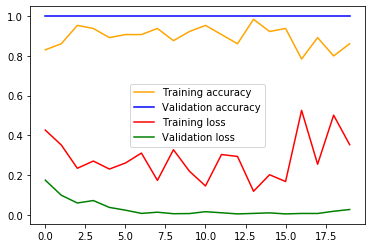

In [414]:
print(history.history.keys())

plt.figure()
plt.plot(history.history['acc'], 'orange', label='Training accuracy')
plt.plot(history.history['val_acc'], 'blue', label='Validation accuracy')
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.show()

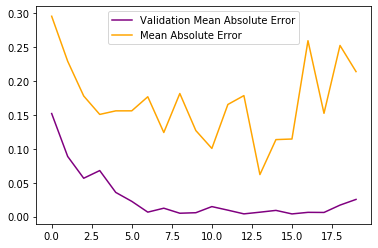

In [415]:
plt.figure()
plt.plot(history.history['val_mean_absolute_error'], 'purple', label='Validation Mean Absolute Error')
plt.plot(history.history['mean_absolute_error'], 'orange', label='Mean Absolute Error')
plt.legend()
plt.show()

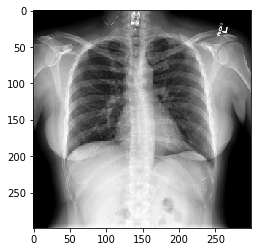

Predicted: [[0.02743657]] Chest X-ray


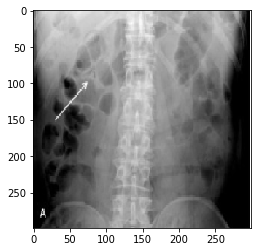

Predicted: [[0.9703975]] Abd X-ray


In [21]:
import numpy as np
from keras.preprocessing import image

img_path= r"C:\Users\benke\Documents\Year 3\Deep Learning\Xray classification\Open_I_abd_vs_CXRs\TRAIN\openI_CXR\3_IM-1384-1001.png"
img_path2= r"C:\Users\benke\Documents\Year 3\Deep Learning\Xray classification\Open_I_abd_vs_CXRs\TRAIN\openI_abd_xray\openI_1.png"
img = image.load_img(img_path, target_size=(img_width, img_height))
img2 = image.load_img(img_path2, target_size=(img_width, img_height))
plt.imshow(img)
plt.show()

img = image.img_to_array(img)
x = np.expand_dims(img, axis=0) * 1./255
score = model.predict(x)
print('Predicted:', score, 'Chest X-ray' if score < 0.5 else 'Abd X-ray')

plt.imshow(img2)
plt.show()

img2 = image.img_to_array(img2)
x = np.expand_dims(img2, axis=0) * 1./255
score2 = model.predict(x)
print('Predicted:', score2, 'Chest X-ray' if score2 < 0.5 else 'Abd X-ray')

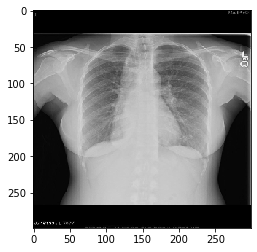

Predicted: [[0.16898718]] Chest X-ray


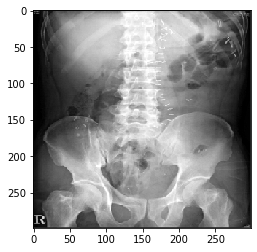

Predicted: [[0.9619189]] Abd X-ray


In [22]:
img_path= r"C:\Users\benke\Documents\Year 3\Deep Learning\Xray classification\Open_I_abd_vs_CXRs\TEST\chest2.png"
img_path2= r"C:\Users\benke\Documents\Year 3\Deep Learning\Xray classification\Open_I_abd_vs_CXRs\TEST\abd2.png"

img = image.load_img(img_path, target_size=(img_width, img_height))
img2 = image.load_img(img_path2, target_size=(img_width, img_height))
plt.imshow(img)
plt.show()

img = image.img_to_array(img)
x = np.expand_dims(img, axis=0) * 1./255
score = model.predict(x)
print('Predicted:', score, 'Chest X-ray' if score < 0.5 else 'Abd X-ray')

plt.imshow(img2)
plt.show()

img2 = image.img_to_array(img2)
x = np.expand_dims(img2, axis=0) * 1./255
score2 = model.predict(x)
print('Predicted:', score2, 'Chest X-ray' if score2 < 0.5 else 'Abd X-ray')

In [23]:
loss = model.evaluate_generator(train_generator, len(train_generator),  workers = 1)
print(model.metrics_names)
print(loss)
print("Accuracy = ", loss[1])

['loss', 'acc', 'mean_absolute_error']
[0.015873397879589062, 1.0, 0.015552858786227612]
Accuracy =  1.0


In [24]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

Y_pred = model.predict_generator(train_generator, 13)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(train_generator.classes, y_pred))

Confusion Matrix
[[33  0]
 [32  0]]
